In [1]:
pip install import_ipynb

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import import_ipynb
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import math 
import matplotlib.pyplot as plt
import math 
import time
from numpy.random import multivariate_normal

# Part I Preparation 
## 1.1 Define the Kuramoto solver

In [8]:
def kuramoto2nd(X,t):
    theta = X[0:n]
    theta = theta-Omee*t
    omega = X[n:2*n]
    dtheta = omega 
    matrix1 = np.repeat(np.reshape(theta,(1,n)),n,axis=0)
    matrix2 = np.transpose(matrix1)-matrix1
    sinmatrix  = np.sin(matrix2)
    domega = (1/M)*(-D*omega+Ome0-K*np.sum(np.multiply(sinmatrix, A),axis=1))
    return np.append(dtheta,domega)
    
                 
def solkuramoto(sol0,dt):
    return odeint(kuramoto2nd,sol0,dt)


## 1.2 Define the global violation check function
### Type 1: ReCof Violation(ReCoF)
### Type 2: Absolute Frequency Violation(AFV)
### Type 3: Any Violation(AV)

In [9]:
def globalcheck(xx,checktimes,thres,n,tt):
    """
    a function returns all check results 

    Parameters
    ----------
    xx : an array 
        numerical solutions of the ode
    checktimes : int
        number of checks 
    thres : a (2,) array
        thres = [thres1, thres2]
    n : int 
        number of nodes
    tt : int
        number of integration steps 
        
    Returns
    -------
    a 3*n array 

    """
    result = np.zeros((3,n))
    checkstep = tt//checktimes
    absxx = np.abs(xx)
    for i in range(n):
        for k in range(2):  
            for j in range(checktimes):
                if(absxx[1+j*checkstep,k*n+i]>thres[k]):
                    result[k,i]=1
                    break  
        result[2,i] = np.max(result[:,i])
     
    return result 


## 1.3 Define the disturbance generating function 

In [10]:
def normaldisturbances(n,k,sigma):
    """
    ...
    Parameters
    ----------
    n : int
        number of nodes 
    k : int 
        sample size
    sigma : float 
        a scalar to control the covariance matrix 

    Returns
    -------
    ...
        (k,n)

    """
    cov = np.eye(n)*sigma 
    mu = np.zeros(n)
    return multivariate_normal(mu,cov,k)
    

 


## 1.4 Import functions from the Network module

In [11]:
from network import unG, kron_reduction, edge_removing, ngnr

# Part 2 Complete networks 
## 2.1 Parameter setting

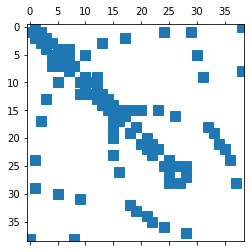

In [63]:
bigA,redL,redA = kron_reduction(unG,ngnr)
# print(redL)
# print(redA)
#visualize the adjacent matrix
import scipy.sparse as sparse
sparseA = sparse.csr_matrix(bigA)
plt.spy(sparseA)


In [64]:
K = 1
A = redA# let the ajacent matrix be the kron-reduced one
n = ngnr #the number of generators 
M = np.array([0.2228, 0.1607, 0.1899, 0.1517, 0.1379, 0.1846, 0.1401, 0.1289, 0.183, 2.6526])
D = np.array([0.0332,0.076,0.0862,0.0838,0.0674,0.0862,0.0743,0.0716,0.1101,0.1333])
Ome = np.zeros(n)

pi = math.pi

t = 15
nn = 100


theta0 = np.zeros(n)
omega0 = np.zeros(n)


#calculate the sychronization frequency
Omee =  np.sum(Ome)/np.sum(D)
Ome0 = Ome-D*Omee



## 2.2 Without disturbances

In [18]:
t=15
nn=1000
dt = np.linspace(0,t, nn+1)
omega0 = np.zeros(n)

sol0 = np.zeros((2*n))
sol0[0:n] = theta0
sol0[n:2*n]= omega0


starttime = time.time()
vec_sol = solkuramoto(sol0, dt)
t2 = time.time()-starttime

sol_theta2 = vec_sol[:,0:n]
sol_omega2 = vec_sol[:,n:2*n]

check_times = 100
all_check = globalcheck(vec_sol, check_times, np.array([1,1]), n, nn)


Text(0.5, 1.0, 'Natural rotation frequencies')

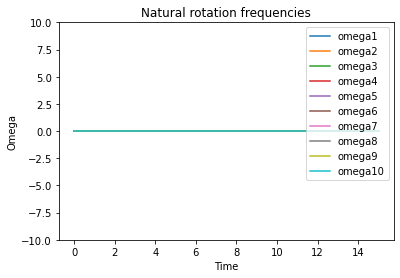

In [21]:
# %% plotting Theta
for i in range(n):
    theta = vec_sol[:,i]
    plt.plot(dt, theta, "-", label="omega"+ str(i+1))


plt.xlabel("Time")
plt.ylabel("Omega")    
plt.ylim(-10, 10)
plt.legend();
plt.title('Natural rotation frequencies')


Text(0.5, 1.0, 'Derivatives of natural rotation frequencies')

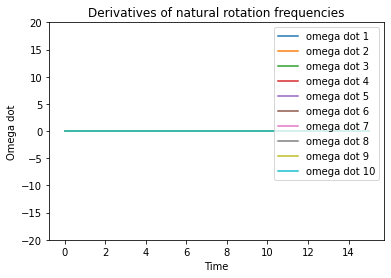

In [22]:
# %% plotting Omega
for i in range(n):
    omega = vec_sol[:,n+i]  
    plt.plot(dt, omega, "-", label="omega dot "+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega dot")
plt.ylim(-20, 20)
plt.legend();
plt.title('Derivatives of natural rotation frequencies')




## 2.3 With normally distributed disturbances 
### 2.3.1 Against different candidates of numbers of checks 

In [ ]:
starttime = time.time()
omega0 = np.zeros(n)
KK = 2#repetition times  
t = 5
nn = 2
dt = np.linspace(0, t, nn+1)
sigma = 0.1
disturb_norm = normaldisturbances(n,KK,sigma)
Ome0 = np.zeros(n)



opt_checks = np.array([10,25,50,100,200,250,500])

num_checks = len(opt_checks)
vcheck_omega = np.zeros((num_checks,n))
vcheck_theta = np.zeros((num_checks,n))
vcheck_any = np.zeros((num_checks,n))


for k in range(KK):
    sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
    vec_sol = solkuramoto(sol0,dt)
    for j in range(num_checks):
        check_times = opt_checks[j]
        all_check = globalcheck(vec_sol, check_times, np.array([0.35,0.5]), n, nn)
        vcheck_theta[j] += all_check[0]
        vcheck_omega[j] += all_check[1]
        vcheck_any[j] += all_check[2]

vcheck_omega = vcheck_omega/KK
vcheck_theta = vcheck_theta/KK
vcheck_any = vcheck_any/KK
    

stoptime = time.time()
totaltime = stoptime-starttime
print("Total time needed= {:2.2}sec".format(totaltime))


In [ ]:
#%% plot against number of checks with the check_any rate 

for i in range(n):
    plt.plot(opt_checks,vcheck_any[:,i],'-',label = 'node'+str(i+1))

plt.xlabel("Sample size")
plt.ylabel("Any-violation rate")
plt.ylim(0, 1)
plt.legend();

In [ ]:
#%% plot against number of checks with the RoCoF rate
for i in range(n):
    plt.plot(opt_checks,vcheck_omega[:,i],'-',label = 'node'+str(i+1))

plt.xlabel("Sample size")
plt.ylabel("RoCoF violation rate")
plt.ylim(0, 1)
plt.legend();


In [ ]:
#%% plot against number of checks with the absolute frequency rate 

for i in range(n):
    plt.plot(opt_checks,vcheck_any[:,i],'-',label = 'node'+str(i+1))

plt.xlabel("Sample size")
plt.ylabel("Absolute frequency violation rate")
plt.ylim(0, 1)
plt.legend();


### 2.3.2 Against different candidates of sample sizes and calculate the std.  

In [ ]:
starttime = time.time()
omega0 = np.zeros(n)
t = 5
nn = 1000
check_times = 100
dt = np.linspace(0, t, nn+1)



Ome0 = np.zeros(n)
sigma = 0.1
NN = 40
opt_size = np.linspace(100, 4000,NN)
vcheck_omega = np.zeros((NN,2))
vcheck_theta = np.zeros((NN,2))
vcheck_any = np.zeros((NN,2))





for i in range(NN):
    KK = int(opt_size[i])
    disturb_norm = normaldisturbances(n,KK,sigma)
    for k in range(KK):
        sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
        vec_sol = solkuramoto(sol0,dt)
        all_check = globalcheck(vec_sol, check_times, np.array([0.35,0.5]), n, nn)
        vcheck_theta[i,0] += np.max(all_check[0])
        vcheck_omega[i,0] += np.max(all_check[1])
        vcheck_any[i,0] += np.max(all_check[2])
  


   
   
    vcheck_theta[i,0] = vcheck_theta[i,0]/KK
    vcheck_theta[i,1] = vcheck_theta[i,0] - vcheck_theta[i,0]**2
    vcheck_omega[i,0] = vcheck_omega[i,0]/KK
    vcheck_omega[i,1] = vcheck_omega[i,0]- vcheck_omega[i,0]**2
    vcheck_any[i,0] = vcheck_any[i,0]/KK
    vcheck_any[i,1] = vcheck_any[i,0] - vcheck_any[i,0]**2






    
        
stoptime = time.time()
totaltime = stoptime-starttime

In [ ]:
#%% plot against number of, AV

c =1.96# at 95% confidence level


plt.plot(opt_size,vcheck_any[:,0],'-',label = 'the any violation rate of the system')


plt.fill_between(opt_size, 
                  vcheck_any[:,0]-c*np.sqrt(vcheck_any[:,1])/np.sqrt(opt_size),
                  vcheck_any[:,0]+c*np.sqrt(vcheck_any[:,1])/np.sqrt(opt_size),
                  color='green', alpha=.5)

plt.xlabel("Sample size")
plt.ylabel("Any-violation rate")
plt.ylim(0.5, 1)
plt.legend();




In [ ]:
#%% plot against sample size, RoCof

c =1.96# at 95% confidence level


plt.plot(opt_size,vcheck_omega[:,0],'-',label = 'the RoCoF rate of the system')


plt.fill_between(opt_size, 
                  vcheck_omega[:,0]-c*np.sqrt(vcheck_omega[:,1])/np.sqrt(opt_size),
                  vcheck_omega[:,0]+c*np.sqrt(vcheck_omega[:,1])/np.sqrt(opt_size),
                  color='green', alpha=.5)

plt.xlabel("Sample size")
plt.ylabel("RoCoF rate")
plt.ylim(0.5, 1)
plt.legend();


In [ ]:
#%% plot against sample size, AFV 

c =1.96# at 95% confidence level


plt.plot(opt_size,vcheck_theta[:,0],'-',label = 'the absolute frequency violation rate of the system')


plt.fill_between(opt_size, 
                  vcheck_theta[:,0]-c*np.sqrt(vcheck_theta[:,1])/np.sqrt(opt_size),
                  vcheck_theta[:,0]+c*np.sqrt(vcheck_theta[:,1])/np.sqrt(opt_size),
                  color='green', alpha=.5)

plt.xlabel("Sample size")
plt.ylabel("Absolute frequency violation rate")
plt.ylim(0.5, 1)
plt.legend();


### 2.3.3 A numerical experiment with the number of checks = 100, and sample size = 1000. 

In [65]:
starttime = time.time()
omega0 = np.zeros(n)
Ome0 = np.zeros(n)
KK =1000#repetition times  
t = 5
nn = 1000
dt = np.linspace(0, t, nn+1)
sigma = 0.05
check_times = 100
thres = np.array([0.35,0.5])


vcheck_omega = np.zeros(n)
vcheck_theta = np.zeros(n)
vcheck_any = np.zeros(n)
mcheck_omega = np.zeros((n,n))
mcheck_theta = np.zeros((n,n))
mcheck_any = np.zeros((n,n))   


disturb_norm = normaldisturbances(n,KK,sigma)

for k in range(KK):
    sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
    vec_sol = solkuramoto(sol0,dt)
    all_check = globalcheck(vec_sol, check_times, thres, n, nn)
    vcheck_theta += all_check[0]
    vcheck_omega += all_check[1]
    vcheck_any += all_check[2]
    
    mcheck_theta += np.outer(all_check[0],all_check[0])
    mcheck_omega += np.outer(all_check[1],all_check[1])
    mcheck_any += np.outer(all_check[2],all_check[2])
    
vcheck_omega = vcheck_omega/KK
vcheck_theta = vcheck_theta/KK
vcheck_any = vcheck_any/KK
mcheck_theta = mcheck_theta/KK
mcheck_omega = mcheck_omega/KK
mcheck_any = mcheck_any /KK


stoptime = time.time()
totaltime = stoptime-starttime
print("Total time needed= {:2.2}sec".format(totaltime))

Total time needed= 2.4e+01sec


In [66]:
print(vcheck_omega)
print(vcheck_theta)
print(vcheck_any)

[0.655 0.45  0.423 0.432 0.495 0.442 0.465 0.451 0.362 0.291]
[0.611 0.219 0.207 0.209 0.274 0.209 0.244 0.211 0.119 0.097]
[0.7   0.45  0.423 0.432 0.495 0.442 0.465 0.451 0.362 0.291]


In [68]:
print(np.mean(vcheck_omega))
print(np.mean(vcheck_theta))
print(np.mean(vcheck_any))

0.4466
0.24
0.4511


Text(0.5, 1.0, 'Natural rotation frequencies')

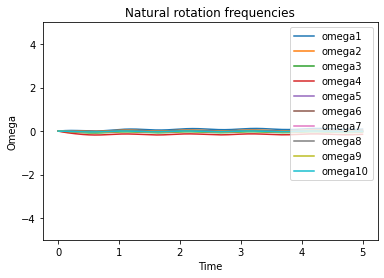

In [27]:
# %% plotting Theta
for i in range(n):
    theta = vec_sol[:,i]
    plt.plot(dt, theta, "-", label="omega"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Omega")    
plt.ylim(-5, 5)
plt.legend();
plt.title('Natural rotation frequencies')



Text(0.5, 1.0, 'Derivatives of natural rotation frequencies')

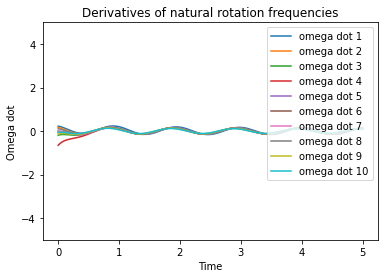

In [28]:
# %% plotting Omega
for i in range(n):
    omega = vec_sol[:,n+i]  
    plt.plot(dt, omega, "-", label="omega dot "+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega dot")
plt.ylim(-5, 5)
plt.legend();
plt.title('Derivatives of natural rotation frequencies')




In [29]:
#%%%against different sigma  or thers
starttime = time.time()
omega0 = np.zeros(n)
KK =1000#repetition times  
t = 5
nn = 1000
dt = np.linspace(0, t, nn+1)
Ome0 = np.zeros(n)
check_times = 100


def simulation(sigma,thres):
    result = np.zeros(4)
    disturb_norm = normaldisturbances(n,KK,sigma)
    for k in range(KK):
        sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
        vec_sol = solkuramoto(sol0,dt)
        all_check = globalcheck(vec_sol, check_times, thres, n, nn)
        result[0] += np.max(all_check[0])
        result[1] += np.max(all_check[1])
        result[2] += np.max(all_check[2])
        result[3] += all_check[0,5]
        
    result[0] = result[0]/KK
    result[1] = result[1]/KK
    result[2] = result[2]/KK
    result[3] = result[3]/KK


    return result 
        

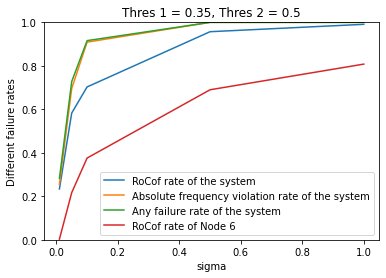

In [30]:
#%%%against sigma  
candidate_sigma = np.array([0.01,0.05,0.1,0.5,1])
thres = np.array([0.35,0.5])
rates_sigma = np.zeros((len(candidate_sigma),4))

for i in range(len(candidate_sigma)):
    rates_sigma[i] = simulation(candidate_sigma[i],thres)
    


# for i in range(4):
#     plt.plot(candidate_sigma,rates_sigma[:,i],'-',label = 'rate'+str(i+1))


plt.plot(candidate_sigma,rates_sigma[:,0],'-',label = 'RoCof rate of the system')
plt.plot(candidate_sigma,rates_sigma[:,1],'-',label = 'Absolute frequency violation rate of the system')
plt.plot(candidate_sigma,rates_sigma[:,2],'-',label = 'Any failure rate of the system')
plt.plot(candidate_sigma,rates_sigma[:,3],'-',label = 'RoCof rate of Node 6')

plt.xlabel("sigma")
plt.ylabel("Different failure rates")
plt.ylim(0, 1)
plt.title("Thres 1 = 0.35, Thres 2 = 0.5")
plt.legend();


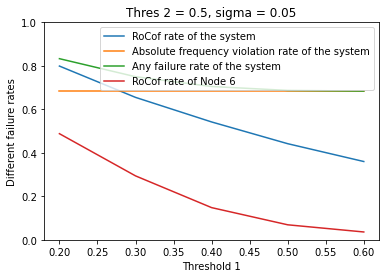

In [34]:

#%%against thres 1 (for the recof)

candidate_thres1 = np.array([0.2,0.3,0.4,0.5,0.6])
rate_thres1 = np.zeros((len(candidate_sigma),4))
thres2 = 0.5
sigma = 0.05

disturb_norm = normaldisturbances(n,KK,sigma)
for k in range(KK):
       sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
       vec_sol = solkuramoto(sol0,dt)
       for i in range(len(candidate_thres1)):
           all_check = globalcheck(vec_sol, check_times, np.array([candidate_thres1[i],thres2]), n, nn)
           rate_thres1[i,0] += np.max(all_check[0])
           rate_thres1[i,1] += np.max(all_check[1])
           rate_thres1[i,2] += np.max(all_check[2])
           rate_thres1[i,3] += all_check[0,5]

            

rate_thres1 =rate_thres1/KK
plt.plot(candidate_thres1,rate_thres1[:,0],'-',label = 'RoCof rate of the system')
plt.plot(candidate_thres1,rate_thres1[:,1],'-',label = 'Absolute frequency violation rate of the system')
plt.plot(candidate_thres1,rate_thres1[:,2],'-',label = 'Any failure rate of the system')
plt.plot(candidate_thres1,rate_thres1[:,3],'-',label = 'RoCof rate of Node 6')

plt.xlabel("Threshold 1")
plt.ylabel("Different failure rates")
plt.ylim(0, 1)
plt.title("Thres 2 = 0.5, sigma = 0.05")
plt.legend();




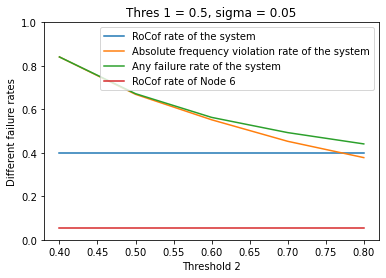

In [32]:
#%%% against thres 2(for the absolute violation rates)
candidate_thres2 = np.array([0.4,0.5,0.6,0.7,0.8])
rate_thres2 = np.zeros((len(candidate_sigma),4))
thres1 = 0.5
sigma = 0.05

disturb_norm = normaldisturbances(n,KK,sigma)
for k in range(KK):
       sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
       vec_sol = solkuramoto(sol0,dt)
       for i in range(len(candidate_thres2))                      :
           all_check = globalcheck(vec_sol, check_times, np.array([thres1,candidate_thres2[i]]), n, nn)
           rate_thres2[i,0] += np.max(all_check[0])
           rate_thres2[i,1] += np.max(all_check[1])
           rate_thres2[i,2] += np.max(all_check[2])
           rate_thres2[i,3] += all_check[0,5]
            

rate_thres2 =rate_thres2/KK
plt.plot(candidate_thres2,rate_thres2[:,0],'-',label = 'RoCof rate of the system')
plt.plot(candidate_thres2,rate_thres2[:,1],'-',label = 'Absolute frequency violation rate of the system')
plt.plot(candidate_thres2,rate_thres2[:,2],'-',label = 'Any failure rate of the system')
plt.plot(candidate_thres2,rate_thres2[:,3],'-',label = 'RoCof rate of Node 6')

plt.xlabel("Threshold 2")
plt.ylabel("Different failure rates")
plt.ylim(0, 1)
plt.title("Thres 1 = 0.5, sigma = 0.05")
plt.legend();

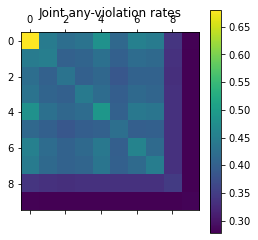

In [33]:

#%%%visulizations of joint stats
plt.matshow(mcheck_any)
plt.title("Joint any-violation rates")
plt.colorbar()


# Part 2 Complete networks 
## 2.1 Parameter setting

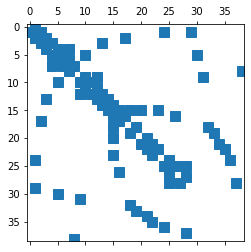

In [62]:
newG = edge_removing(unG, [1,39])
bigA,redL,redA = kron_reduction(newG,ngnr)
# print(redL)
# print(redA)
#visualize the adjacent matrix
import scipy.sparse as sparse
sparseA = sparse.csr_matrix(bigA)
plt.spy(sparseA)

K = 1
A = redA# let the ajacent matrix be the kron-reduced one
n = ngnr #the number of generators 
M = np.array([0.2228, 0.1607, 0.1899, 0.1517, 0.1379, 0.1846, 0.1401, 0.1289, 0.183, 2.6526])
D = np.array([0.0332,0.076,0.0862,0.0838,0.0674,0.0862,0.0743,0.0716,0.1101,0.1333])
Ome = np.zeros(n)

pi = math.pi

t = 15
nn = 100


theta0 = np.zeros(n)
omega0 = np.zeros(n)


#calculate the sychronization frequency
Omee =  np.sum(Ome)/np.sum(D)
Ome0 = Ome-D*Omee



## 2.2 Without disturbances

In [18]:
t=15
nn=1000
dt = np.linspace(0,t, nn+1)
omega0 = np.zeros(n)

sol0 = np.zeros((2*n))
sol0[0:n] = theta0
sol0[n:2*n]= omega0


starttime = time.time()
vec_sol = solkuramoto(sol0, dt)
t2 = time.time()-starttime

sol_theta2 = vec_sol[:,0:n]
sol_omega2 = vec_sol[:,n:2*n]

check_times = 100
all_check = globalcheck(vec_sol, check_times, np.array([1,1]), n, nn)


Text(0.5, 1.0, 'Natural rotation frequencies')

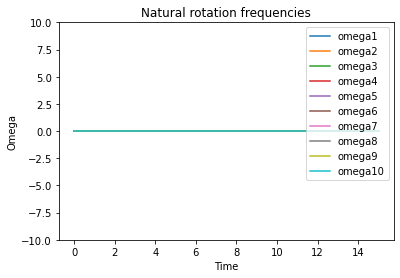

In [21]:
# %% plotting Theta
for i in range(n):
    theta = vec_sol[:,i]
    plt.plot(dt, theta, "-", label="omega"+ str(i+1))


plt.xlabel("Time")
plt.ylabel("Omega")    
plt.ylim(-10, 10)
plt.legend();
plt.title('Natural rotation frequencies')


Text(0.5, 1.0, 'Derivatives of natural rotation frequencies')

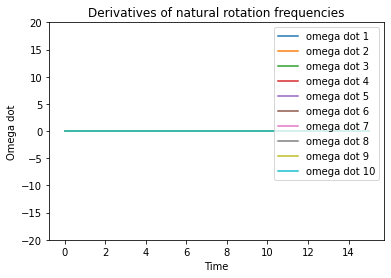

In [22]:
# %% plotting Omega
for i in range(n):
    omega = vec_sol[:,n+i]  
    plt.plot(dt, omega, "-", label="omega dot "+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega dot")
plt.ylim(-20, 20)
plt.legend();
plt.title('Derivatives of natural rotation frequencies')




## 2.3 With normally distributed disturbances 
### 2.3.1 Against different candidates of numbers of checks 

In [ ]:
starttime = time.time()
omega0 = np.zeros(n)
KK = 2#repetition times  
t = 5
nn = 2
dt = np.linspace(0, t, nn+1)
sigma = 0.1
disturb_norm = normaldisturbances(n,KK,sigma)
Ome0 = np.zeros(n)



opt_checks = np.array([10,25,50,100,200,250,500])

num_checks = len(opt_checks)
vcheck_omega = np.zeros((num_checks,n))
vcheck_theta = np.zeros((num_checks,n))
vcheck_any = np.zeros((num_checks,n))


for k in range(KK):
    sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
    vec_sol = solkuramoto(sol0,dt)
    for j in range(num_checks):
        check_times = opt_checks[j]
        all_check = globalcheck(vec_sol, check_times, np.array([0.35,0.5]), n, nn)
        vcheck_theta[j] += all_check[0]
        vcheck_omega[j] += all_check[1]
        vcheck_any[j] += all_check[2]

vcheck_omega = vcheck_omega/KK
vcheck_theta = vcheck_theta/KK
vcheck_any = vcheck_any/KK
    

stoptime = time.time()
totaltime = stoptime-starttime
print("Total time needed= {:2.2}sec".format(totaltime))


In [ ]:
#%% plot against number of checks with the check_any rate 

for i in range(n):
    plt.plot(opt_checks,vcheck_any[:,i],'-',label = 'node'+str(i+1))

plt.xlabel("Sample size")
plt.ylabel("Any-violation rate")
plt.ylim(0, 1)
plt.legend();

In [ ]:
#%% plot against number of checks with the RoCoF rate
for i in range(n):
    plt.plot(opt_checks,vcheck_omega[:,i],'-',label = 'node'+str(i+1))

plt.xlabel("Sample size")
plt.ylabel("RoCoF violation rate")
plt.ylim(0, 1)
plt.legend();


In [ ]:
#%% plot against number of checks with the absolute frequency rate 

for i in range(n):
    plt.plot(opt_checks,vcheck_any[:,i],'-',label = 'node'+str(i+1))

plt.xlabel("Sample size")
plt.ylabel("Absolute frequency violation rate")
plt.ylim(0, 1)
plt.legend();


### 2.3.2 Against different candidates of sample sizes and calculate the std.  

In [ ]:
starttime = time.time()
omega0 = np.zeros(n)
t = 5
nn = 1000
check_times = 100
dt = np.linspace(0, t, nn+1)



Ome0 = np.zeros(n)
sigma = 0.1
NN = 40
opt_size = np.linspace(100, 4000,NN)
vcheck_omega = np.zeros((NN,2))
vcheck_theta = np.zeros((NN,2))
vcheck_any = np.zeros((NN,2))





for i in range(NN):
    KK = int(opt_size[i])
    disturb_norm = normaldisturbances(n,KK,sigma)
    for k in range(KK):
        sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
        vec_sol = solkuramoto(sol0,dt)
        all_check = globalcheck(vec_sol, check_times, np.array([0.35,0.5]), n, nn)
        vcheck_theta[i,0] += np.max(all_check[0])
        vcheck_omega[i,0] += np.max(all_check[1])
        vcheck_any[i,0] += np.max(all_check[2])
  


   
   
    vcheck_theta[i,0] = vcheck_theta[i,0]/KK
    vcheck_theta[i,1] = vcheck_theta[i,0] - vcheck_theta[i,0]**2
    vcheck_omega[i,0] = vcheck_omega[i,0]/KK
    vcheck_omega[i,1] = vcheck_omega[i,0]- vcheck_omega[i,0]**2
    vcheck_any[i,0] = vcheck_any[i,0]/KK
    vcheck_any[i,1] = vcheck_any[i,0] - vcheck_any[i,0]**2






    
        
stoptime = time.time()
totaltime = stoptime-starttime

In [ ]:
#%% plot against number of, AV

c =1.96# at 95% confidence level


plt.plot(opt_size,vcheck_any[:,0],'-',label = 'the any violation rate of the system')


plt.fill_between(opt_size, 
                  vcheck_any[:,0]-c*np.sqrt(vcheck_any[:,1])/np.sqrt(opt_size),
                  vcheck_any[:,0]+c*np.sqrt(vcheck_any[:,1])/np.sqrt(opt_size),
                  color='green', alpha=.5)

plt.xlabel("Sample size")
plt.ylabel("Any-violation rate")
plt.ylim(0.5, 1)
plt.legend();




In [ ]:
#%% plot against sample size, RoCof

c =1.96# at 95% confidence level


plt.plot(opt_size,vcheck_omega[:,0],'-',label = 'the RoCoF rate of the system')


plt.fill_between(opt_size, 
                  vcheck_omega[:,0]-c*np.sqrt(vcheck_omega[:,1])/np.sqrt(opt_size),
                  vcheck_omega[:,0]+c*np.sqrt(vcheck_omega[:,1])/np.sqrt(opt_size),
                  color='green', alpha=.5)

plt.xlabel("Sample size")
plt.ylabel("RoCoF rate")
plt.ylim(0.5, 1)
plt.legend();


In [ ]:
#%% plot against sample size, AFV 

c =1.96# at 95% confidence level


plt.plot(opt_size,vcheck_theta[:,0],'-',label = 'the absolute frequency violation rate of the system')


plt.fill_between(opt_size, 
                  vcheck_theta[:,0]-c*np.sqrt(vcheck_theta[:,1])/np.sqrt(opt_size),
                  vcheck_theta[:,0]+c*np.sqrt(vcheck_theta[:,1])/np.sqrt(opt_size),
                  color='green', alpha=.5)

plt.xlabel("Sample size")
plt.ylabel("Absolute frequency violation rate")
plt.ylim(0.5, 1)
plt.legend();


### 2.3.3 A numerical experiment with the number of checks = 100, and sample size = 1000. 
### (1) Removing edge(20,34)

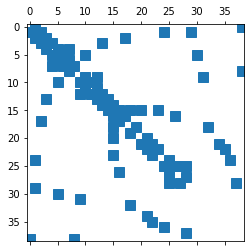

In [74]:
newG = edge_removing(unG, [20,34])
bigA,redL,redA = kron_reduction(newG,ngnr)
# print(redL)
# print(redA)
#visualize the adjacent matrix
import scipy.sparse as sparse
sparseA = sparse.csr_matrix(bigA)
plt.spy(sparseA)

K = 1
A = redA# let the ajacent matrix be the kron-reduced one
n = ngnr #the number of generators 
M = np.array([0.2228, 0.1607, 0.1899, 0.1517, 0.1379, 0.1846, 0.1401, 0.1289, 0.183, 2.6526])
D = np.array([0.0332,0.076,0.0862,0.0838,0.0674,0.0862,0.0743,0.0716,0.1101,0.1333])
Ome = np.zeros(n)

pi = math.pi

t = 15
nn = 100


theta0 = np.zeros(n)
omega0 = np.zeros(n)


#calculate the sychronization frequency
Omee =  np.sum(Ome)/np.sum(D)
Ome0 = Ome-D*Omee



In [75]:
starttime = time.time()
omega0 = np.zeros(n)
Ome0 = np.zeros(n)
KK =1000#repetition times  
t = 5
nn = 1000
dt = np.linspace(0, t, nn+1)
sigma = 0.05
check_times = 100
thres = np.array([0.35,0.5])


vcheck_omega = np.zeros(n)
vcheck_theta = np.zeros(n)
vcheck_any = np.zeros(n)
mcheck_omega = np.zeros((n,n))
mcheck_theta = np.zeros((n,n))
mcheck_any = np.zeros((n,n))   


disturb_norm = normaldisturbances(n,KK,sigma)

for k in range(KK):
    sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
    vec_sol = solkuramoto(sol0,dt)
    all_check = globalcheck(vec_sol, check_times, thres, n, nn)
    vcheck_theta += all_check[0]
    vcheck_omega += all_check[1]
    vcheck_any += all_check[2]
    
    mcheck_theta += np.outer(all_check[0],all_check[0])
    mcheck_omega += np.outer(all_check[1],all_check[1])
    mcheck_any += np.outer(all_check[2],all_check[2])
    
vcheck_omega = vcheck_omega/KK
vcheck_theta = vcheck_theta/KK
vcheck_any = vcheck_any/KK
mcheck_theta = mcheck_theta/KK
mcheck_omega = mcheck_omega/KK
mcheck_any = mcheck_any /KK


stoptime = time.time()
totaltime = stoptime-starttime
print("Total time needed= {:2.2}sec".format(totaltime))

Total time needed= 2.5e+01sec


Text(0.5, 1.0, 'Derivatives of natural rotation frequencies')

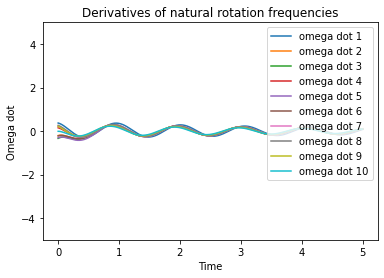

In [76]:
# %% plotting Omega
for i in range(n):
    omega = vec_sol[:,n+i]  
    plt.plot(dt, omega, "-", label="omega dot "+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega dot")
plt.ylim(-5, 5)
plt.legend();
plt.title('Derivatives of natural rotation frequencies')




Text(0.5, 1.0, 'Natural rotation frequencies')

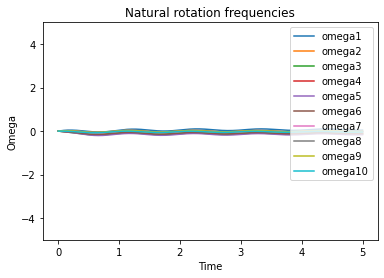

In [77]:
# %% plotting Theta
for i in range(n):
    theta = vec_sol[:,i]
    plt.plot(dt, theta, "-", label="omega"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Omega")    
plt.ylim(-5, 5)
plt.legend();
plt.title('Natural rotation frequencies')



In [78]:
print(vcheck_omega)
print(vcheck_theta)
print(vcheck_any)

[0.596 0.441 0.415 0.416 0.457 0.42  0.437 0.435 0.332 0.284]
[0.584 0.22  0.202 0.203 0.293 0.218 0.23  0.21  0.119 0.08 ]
[0.645 0.441 0.415 0.416 0.457 0.42  0.437 0.435 0.332 0.284]


In [79]:
print(np.mean(vcheck_omega))
print(np.mean(vcheck_theta))
print(np.mean(vcheck_any))

0.42329999999999995
0.2359
0.4282


### (2) Removing edge(15,16)

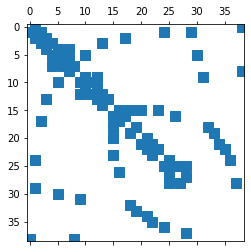

In [69]:
newG = edge_removing(unG, [15,16])
bigA,redL,redA = kron_reduction(newG,ngnr)
# print(redL)
# print(redA)
#visualize the adjacent matrix
import scipy.sparse as sparse
sparseA = sparse.csr_matrix(bigA)
plt.spy(sparseA)

K = 1
A = redA# let the ajacent matrix be the kron-reduced one
n = ngnr #the number of generators 
M = np.array([0.2228, 0.1607, 0.1899, 0.1517, 0.1379, 0.1846, 0.1401, 0.1289, 0.183, 2.6526])
D = np.array([0.0332,0.076,0.0862,0.0838,0.0674,0.0862,0.0743,0.0716,0.1101,0.1333])
Ome = np.zeros(n)

pi = math.pi

t = 15
nn = 100


theta0 = np.zeros(n)
omega0 = np.zeros(n)


#calculate the sychronization frequency
Omee =  np.sum(Ome)/np.sum(D)
Ome0 = Ome-D*Omee



In [70]:
starttime = time.time()
omega0 = np.zeros(n)
Ome0 = np.zeros(n)
KK =1000#repetition times  
t = 5
nn = 1000
dt = np.linspace(0, t, nn+1)
sigma = 0.05
check_times = 100
thres = np.array([0.35,0.5])


vcheck_omega = np.zeros(n)
vcheck_theta = np.zeros(n)
vcheck_any = np.zeros(n)
mcheck_omega = np.zeros((n,n))
mcheck_theta = np.zeros((n,n))
mcheck_any = np.zeros((n,n))   



disturb_norm = normaldisturbances(n,KK,sigma)

for k in range(KK):
    sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
    vec_sol = solkuramoto(sol0,dt)
    all_check = globalcheck(vec_sol, check_times, thres, n, nn)
    vcheck_theta += all_check[0]
    vcheck_omega += all_check[1]
    vcheck_any += all_check[2]
    

    
    mcheck_theta += np.outer(all_check[0],all_check[0])
    mcheck_omega += np.outer(all_check[1],all_check[1])
    mcheck_any += np.outer(all_check[2],all_check[2])
    
vcheck_omega = vcheck_omega/KK
vcheck_theta = vcheck_theta/KK
vcheck_any = vcheck_any/KK
mcheck_theta = mcheck_theta/KK
mcheck_omega = mcheck_omega/KK
mcheck_any = mcheck_any /KK


stoptime = time.time()
totaltime = stoptime-starttime
print("Total time needed= {:2.2}sec".format(totaltime))

Total time needed= 2.5e+01sec


In [71]:
print(vcheck_omega)
print(vcheck_theta)
print(vcheck_any)

[0.634 0.456 0.443 0.446 0.492 0.445 0.466 0.459 0.365 0.299]
[0.605 0.202 0.179 0.199 0.291 0.197 0.228 0.204 0.106 0.085]
[0.684 0.456 0.444 0.446 0.492 0.445 0.466 0.459 0.365 0.299]


In [73]:
print(np.mean(vcheck_omega))
print(np.mean(vcheck_theta))
print(np.mean(vcheck_any))

0.45050000000000007
0.22959999999999997
0.4556000000000001


Text(0.5, 1.0, 'Natural rotation frequencies')

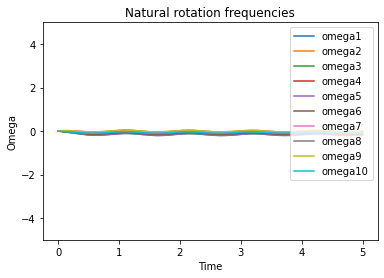

In [50]:
# %% plotting Theta
for i in range(n):
    theta = vec_sol[:,i]
    plt.plot(dt, theta, "-", label="omega"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Omega")    
plt.ylim(-5, 5)
plt.legend();
plt.title('Natural rotation frequencies')



Text(0.5, 1.0, 'Derivatives of natural rotation frequencies')

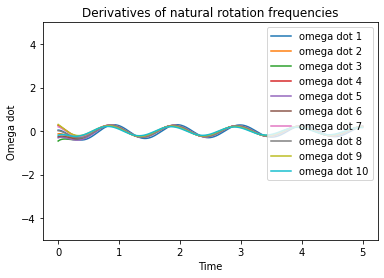

In [51]:
# %% plotting Omega
for i in range(n):
    omega = vec_sol[:,n+i]  
    plt.plot(dt, omega, "-", label="omega dot "+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega dot")
plt.ylim(-5, 5)
plt.legend();
plt.title('Derivatives of natural rotation frequencies')




### (3) Removing edge(23,24)

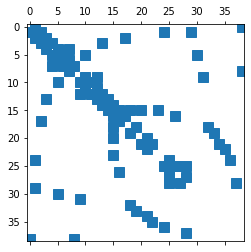

In [81]:
newG = edge_removing(unG, [23,24])
bigA,redL,redA = kron_reduction(newG,ngnr)
# print(redL)
# print(redA)
#visualize the adjacent matrix
import scipy.sparse as sparse
sparseA = sparse.csr_matrix(bigA)
plt.spy(sparseA)

K = 1
A = redA# let the ajacent matrix be the kron-reduced one
n = ngnr #the number of generators 
M = np.array([0.2228, 0.1607, 0.1899, 0.1517, 0.1379, 0.1846, 0.1401, 0.1289, 0.183, 2.6526])
D = np.array([0.0332,0.076,0.0862,0.0838,0.0674,0.0862,0.0743,0.0716,0.1101,0.1333])
Ome = np.zeros(n)

pi = math.pi

t = 15
nn = 100


theta0 = np.zeros(n)
omega0 = np.zeros(n)


#calculate the sychronization frequency
Omee =  np.sum(Ome)/np.sum(D)
Ome0 = Ome-D*Omee



In [82]:
starttime = time.time()
omega0 = np.zeros(n)
Ome0 = np.zeros(n)
KK =1000#repetition times  
t = 5
nn = 1000
dt = np.linspace(0, t, nn+1)
sigma = 0.05
check_times = 100
thres = np.array([0.35,0.5])


vcheck_omega = np.zeros(n)
vcheck_theta = np.zeros(n)
vcheck_any = np.zeros(n)
mcheck_omega = np.zeros((n,n))
mcheck_theta = np.zeros((n,n))
mcheck_any = np.zeros((n,n))   


disturb_norm = normaldisturbances(n,KK,sigma)

for k in range(KK):
    sol0 = np.pad(disturb_norm[k], (n,0), 'constant', constant_values=(0,0))
    vec_sol = solkuramoto(sol0,dt)
    all_check = globalcheck(vec_sol, check_times, thres, n, nn)
    vcheck_theta += all_check[0]
    vcheck_omega += all_check[1]
    vcheck_any += all_check[2]
    
    mcheck_theta += np.outer(all_check[0],all_check[0])
    mcheck_omega += np.outer(all_check[1],all_check[1])
    mcheck_any += np.outer(all_check[2],all_check[2])
    
vcheck_omega = vcheck_omega/KK
vcheck_theta = vcheck_theta/KK
vcheck_any = vcheck_any/KK
mcheck_theta = mcheck_theta/KK
mcheck_omega = mcheck_omega/KK
mcheck_any = mcheck_any /KK


stoptime = time.time()
totaltime = stoptime-starttime
print("Total time needed= {:2.2}sec".format(totaltime))

Total time needed= 2.8e+01sec


In [83]:
print(vcheck_omega)
print(vcheck_theta)
print(vcheck_any)

[0.627 0.457 0.424 0.434 0.495 0.437 0.473 0.454 0.362 0.286]
[0.607 0.213 0.179 0.189 0.267 0.198 0.227 0.211 0.103 0.074]
[0.666 0.457 0.424 0.434 0.495 0.437 0.473 0.454 0.362 0.286]


In [86]:
print(np.mean(vcheck_omega))
print(np.mean(vcheck_theta))
print(np.mean(vcheck_any))

0.44489999999999996
0.22680000000000003
0.4488


Text(0.5, 1.0, 'Natural rotation frequencies')

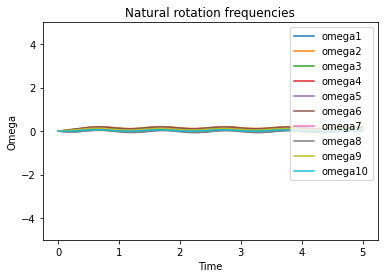

In [84]:
# %% plotting Theta
for i in range(n):
    theta = vec_sol[:,i]
    plt.plot(dt, theta, "-", label="omega"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Omega")    
plt.ylim(-5, 5)
plt.legend();
plt.title('Natural rotation frequencies')



Text(0.5, 1.0, 'Derivatives of natural rotation frequencies')

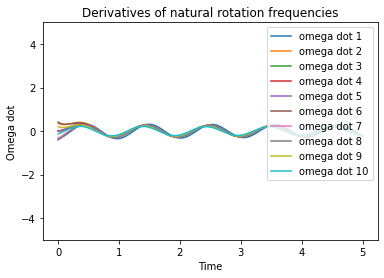

In [85]:
# %% plotting Omega
for i in range(n):
    omega = vec_sol[:,n+i]  
    plt.plot(dt, omega, "-", label="omega dot "+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega dot")
plt.ylim(-5, 5)
plt.legend();
plt.title('Derivatives of natural rotation frequencies')


